<a href="https://www.kaggle.com/code/dalloliogm/pgs5e8-bank-autogluon?scriptVersionId=253830611" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank classification using Autogluon


Autogluon is a auto-ML library from Amazon. It can automatically try several approaches for prediction, and choose the optimal parameters given target metrics to optimize. It also automatically handles cross-validation, although that is not always enabled for all the presets.

Feel free to copy this notebook and adapt it. Some ideas on how to improve it:
- add more feature engineering
- Try different autogluon presets, or run it for longer
- Tweak the autogluon hyperparameters to add/remove more models
- Plot results and inspect them

## Install Libraries and set Configuration

Installing Autogluon takes time, on Kaggle, but once that is done, we don't need anything else.

In [1]:
# %%capture
# !pip install -U autogluon

In [2]:
%%capture
!pip install -q xgboost==1.7.6 scikit-learn==1.3.2

In [3]:
%%capture
import os
import shutil
import seaborn as sns

target_dir = "/kaggle/working/"
source_dir = "/kaggle/input/autogluon-package/"

if not os.path.exists(os.path.join(target_dir, "autogluon")):
    shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
    print("Copied autogluon installation files.")

!pip install -f --quiet --no-index --find-links='/kaggle/input/autogluon-package' 'autogluon.tabular-1.3.1-py3-none-any.whl'


In [4]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    #                  minutes     seconds       # hours
    "autogluon_time": 60       *  60        *   3,
    "autogluon_preset": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file. Useful for debugging
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_preset"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 10800, 'autogluon_preset': 'best_quality', 'tail_rows': 0}


In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Autogluon parameters

In [6]:
hyperparameters = {
    'GBM': {},      # LightGBM
    'CAT': {},      # CatBoost
    'RF': {},       # RandomForest
    'XT': {},       # ExtraTrees
    'KNN': {},      # k-NN
    # 'NN': {},       # MXNet neural-net
    'LR': {},       # LinearModel
    'XGB': {        # XGBoost 
    },
    'TABPFN': {},
    'ENS_WEIGHTED' : {},
    'NN_TORCH': {},
    'IM_BOOSTEDRULES' : {}
}

# 'RF', 'XT', 'KNN', 'GBM', 'CAT', 'XGB', 'NN_TORCH', 'LR', 'FASTAI', 'AG_TEXT_NN', 'AG_IMAGE_NN', 
# 'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 'FASTTEXT', 'ENS_WEIGHTED', 'SIMPLE_ENS_WEIGHTED',
# 'IM_RULEFIT', 'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 'IM_BOOSTEDRULES', 'DUMMY']

## Load Data

In [7]:
import pandas as pd
# data
path        = '/kaggle/input/playground-series-s5e8/'
train       = pd.read_csv(path + 'train.csv',             index_col = 'id')
test        = pd.read_csv(path + 'test.csv',              index_col = 'id')
submission  = pd.read_csv(path + 'sample_submission.csv', index_col = 'id')

# Reduce dataset size for debugging
if config["tail_rows"] > 0:
    train = train.head(config["tail_rows"])

In [8]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [9]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [10]:
submission.head

<bound method NDFrame.head of           y
id         
750000  0.5
750001  0.5
750002  0.5
750003  0.5
750004  0.5
...     ...
999995  0.5
999996  0.5
999997  0.5
999998  0.5
999999  0.5

[250000 rows x 1 columns]>

## Feature Engineering

Some FE suggested by ChatGPT

In [11]:
import numpy as np
import pandas as pd

def engineer_features(df):
    df = df.copy()

    # 1. Convert month from categorical string to numeric (e.g. 'jan' → 1)
    month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    df['month_num'] = df['month'].map(month_map)

    # 2. Create binary flag: was the client previously contacted?
    # 'pdays == -1' means never contacted before
    df['previously_contacted'] = (df['pdays'] != -1).astype(int)

    # 3. Bucket balance into quartiles to capture non-linear effects
    # This helps with skewed distributions of balance
    if 'balance' in df.columns and df['balance'].nunique() > 4:
        df['balance_bucket'] = pd.qcut(df['balance'], q=4, labels=False, duplicates='drop')

    # 4. Create interaction between job and education
    # Some job+education combos may be more likely to subscribe
    df['job_edu'] = df['job'].astype(str) + "_" + df['education'].astype(str)

    # 5. Transform campaign count:
    #   - log1p: dampen the effect of high campaign numbers (long tail)
    #   - is_first_contact: whether this was the client’s first contact
    df['log_campaign'] = np.log1p(df['campaign'])
    df['is_first_contact'] = (df['campaign'] == 1).astype(int)

    # 6. Frequency encode selected categorical features
    # Replace each category with its relative frequency in the dataset
    # Helps add ordinal signal without increasing dimensionality
    for col in ['job', 'poutcome']:
        freq = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freq)

    return df


In [12]:
train_fe = engineer_features(train)
test_fe = engineer_features(test)


# Set up Training

In [13]:
predictor = TabularPredictor(
    label='y',
    problem_type='binary',
    eval_metric="roc_auc",
).fit(
    train_fe,
    hyperparameters=hyperparameters,
    time_limit=config["autogluon_time"],
    presets=config["autogluon_preset"],
    ag_args_fit={'num_gpus': 1},
    verbosity=1
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250802_115055"
/usr/local/lib/python3.11/dist-packages/autogluon/tabular/predictor/predictor.py:1382: UserWarning: Failed to use ray for memory safe fits. Falling back to normal fit. Error: ValueError('ray==2.47.1 detected. 2.10.0 <= ray < 2.45.0 is required. You can use pip to install certain version of ray `pip install "ray>=2.10.0,<2.45.0"`')
  stacked_overfitting = self._sub_fit_memory_save_wrapper(
		No module named 'tabpfn'
Will use sequential fold fitting strategy because import of ray failed. Reason: ray==2.47.1 detected. 2.10.0 <= ray < 2.45.0 is required. You can use pip to install certain version of ray `pip install "ray>=2.10.0,<2.45.0"`
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 w

[12:07:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:08:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:08:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:10:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:10:23] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:11:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:11:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:13:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:13:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:14:48] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:14:53] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:16:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

		Unable to import dependency imodels. A quick tip is to install via `pip install imodels`. 
		No module named 'tabpfn'
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[12:28:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:29:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:29:34] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:30:13] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:30:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:31:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:31:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:31:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:31:57] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:32:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:32:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[12:33:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

		No module named 'tabpfn'
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[13:03:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:09:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:09:57] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:16:24] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:16:30] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:23:06] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:23:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:30:06] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:30:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:37:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:37:33] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[13:45:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[14:18:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:21:20] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:21:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:24:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:24:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:28:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:28:23] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:31:56] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:32:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:35:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:35:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:39:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
	Early stopping due to lack of time remaining. Fit 100/10000 iters...


In [14]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.969445,roc_auc,179.930748,7597.847615,0.125751,46.543927,3,True,15
1,LightGBM_BAG_L2,0.969283,roc_auc,151.224265,5191.217245,2.270167,52.990424,2,True,9
2,XGBoost_BAG_L2,0.969232,roc_auc,152.942102,7030.467342,3.988004,1892.240521,2,True,13
3,CatBoost_BAG_L2,0.969118,roc_auc,150.342351,5386.297608,1.388252,248.070787,2,True,11
4,WeightedEnsemble_L2,0.968725,roc_auc,114.137462,709.529052,0.128759,25.329400,2,True,8
5,RandomForest_BAG_L2,0.968705,roc_auc,172.158574,5358.001956,23.204475,219.775135,2,True,10
6,WeightedEnsemble_BAG_L2,0.968626,roc_auc,148.967683,5187.997144,0.013584,49.770323,2,True,14
7,LightGBM_BAG_L1,0.968558,roc_auc,84.899060,533.063068,84.899060,533.063068,1,True,2
8,ExtraTrees_BAG_L2,0.968251,roc_auc,172.487122,5228.701093,23.533023,90.474272,2,True,12
9,CatBoost_BAG_L1,0.964892,roc_auc,4.196736,611.082888,4.196736,611.082888,1,True,4


In [15]:
import matplotlib.pyplot as plt

# Compute and plot feature importance
importance_df = predictor.feature_importance(data=train_fe)


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:51:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:53:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:48] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:53:53] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:54:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:56:11] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:13] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:56:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:58:35] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:41] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:42] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:58:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[14:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[14:59:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[15:01:00] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:05] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:05] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:01:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[15:03:24] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:25] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:25] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:30] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:03:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

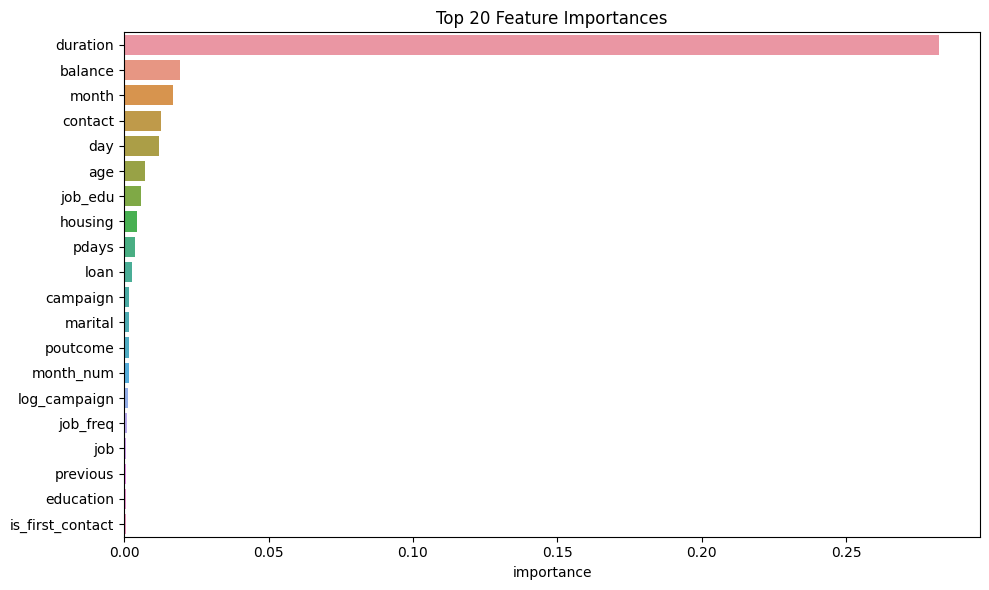

In [16]:
top_features = importance_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y=top_features.index)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Save Submission

In [17]:
%%capture
preds = predictor.predict_proba(test_fe)
preds

In [18]:
preds = predictor.predict_proba(test_fe)[1]
submission['y'] = preds
submission = submission.reset_index()
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[15:12:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:20] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:22] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:24] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:41] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:12:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

## Prediction distributions

This dataset is unbalanced, as there about 3x 0s than 1s.

Autogluon should handle it automatically, although the predictions do not look very good, as they don't have the same distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Observed Y')

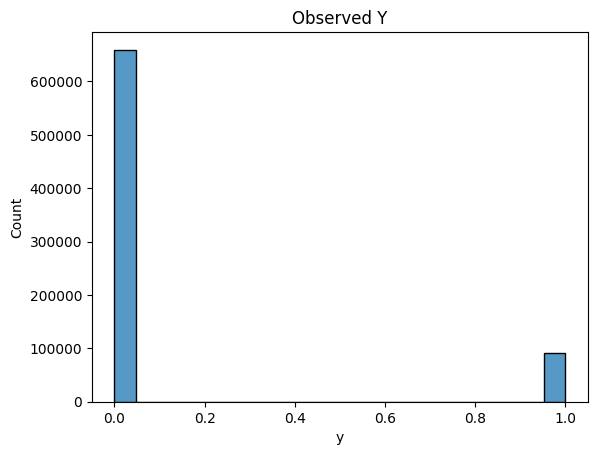

In [19]:
sns.histplot(train_fe.y).set_title("Observed Y")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted Y')

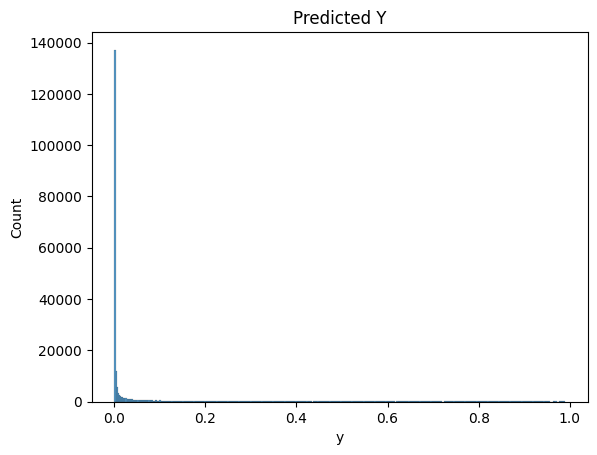

In [20]:
import seaborn as sns
sns.histplot(submission.y).set_title("Predicted Y")

### AUC plot

We plot the ROC Curve, although we use the train test, as cross validation is handled internally by Autogluon and we did not split train/test.



/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[15:24:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:24:32] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:24:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:24:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:24:49] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:24:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:25:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:25:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:25:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:25:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:25:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[15:25:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

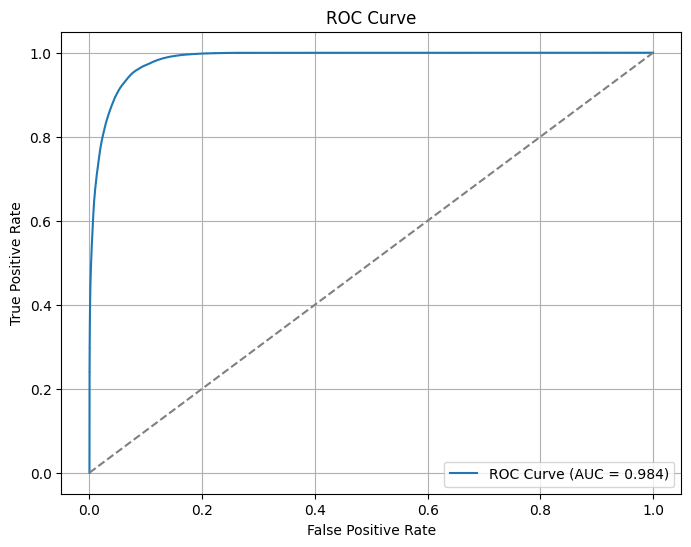

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities (for class 1)
y_true = train_fe['y']
y_pred = predictor.predict_proba(train_fe.drop(columns=['y']))[1]

# Step 2: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Cleanup

Delete all the files for installing Autogluon - let's save Kaggle a bit of disk storage costs.

In [22]:
if not is_interactive_session():
    os.system("rm -rf /kaggle/working/*")
    print("Clean-up complete: deleted files from /kaggle/working/")
else:
    print("Not an interactive session. Skipping clean-up.")

Clean-up complete: deleted files from /kaggle/working/


In [23]:
# Save submission
submission.to_csv('submission.csv', index=False)